# Analyze the extracted sequences for training

> "Before we train, lets see what our corpus is like."

In [ ]:
#| default_exp analysis.training

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from Bio import SeqIO

/home/jdb/projects/llm-mito-scanner/venv/lib/python3.10/site-packages/Bio/__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: /home/jdb/projects/llm-mito-scanner/venv/lib/python3.10/site-packages
  warnings.warn(


In [ ]:
#| hide
from yaml import safe_load

tqdm.pandas(ncols=80, leave=False)

with open("../config.yml") as f:
    config = safe_load(f)

In [ ]:
#| hide
import json

data_path = Path(config.get("data_path"))
annotations_path = data_path / "annotations"
genome_path = data_path / "genome"
sequences_path = data_path / "entrez_genes_sequences"
protein_path = data_path / "protein"
training_data_path = data_path / "training"

## Indexing what data we have

> "How much data did we extract / generate?"

In [ ]:
#| hide
# Training data is organized by annotation id, then gene
training_annotation_directories = pd.Series(training_data_path.glob("*"))
training_annotation_directories.name = "annotation_path"
training_data = training_annotation_directories.to_frame()
training_data.loc[:, 'annotation'] = training_data.annotation_path.apply(lambda p: p.stem)
print(training_data.shape[0])
training_data.head()

560


,annotation_path,annotation
0,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,NC_000001
1,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,NC_000002
2,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,NC_000003
3,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,NC_000004
4,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,NC_000005


In [ ]:
#| hide
# Which of these directories has nothing but the gene to protein map?
training_data.loc[:, 'annotation_objects'] = training_data.annotation_path.apply(lambda p: list(p.glob("*")))
training_data.annotation_objects.iloc[:5]

0    [/mnt/e/Data/llm-mito-scanner-data/data/traini...
1    [/mnt/e/Data/llm-mito-scanner-data/data/traini...
2    [/mnt/e/Data/llm-mito-scanner-data/data/traini...
3    [/mnt/e/Data/llm-mito-scanner-data/data/traini...
4    [/mnt/e/Data/llm-mito-scanner-data/data/traini...
Name: annotation_objects, dtype: object

In [ ]:
#| hide
# How many objects are under each annotation directory in total?
training_data.annotation_objects.apply(len).sum()

16866

In [ ]:
#| hide
# How many objects are under each annotation directory?
training_data.annotation_objects.apply(len).describe()

count     560.000000
mean       30.117857
std       150.516453
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1278.000000
Name: annotation_objects, dtype: float64

In [ ]:
#| export
def detect_gene_to_protein_map(list_of_paths: list[Path]):
    list_of_paths_is_protein_map = [p for p in list_of_paths if p.stem == "gene_to_protein_map"]
    if len(list_of_paths_is_protein_map) == 0:
        return None
    elif len(list_of_paths_is_protein_map) > 1:
        raise ValueError("Somehow there are two gene to protein maps")
    return list_of_paths_is_protein_map[0]

In [ ]:
#| hide
training_data.loc[:, 'protein_map_file'] = training_data.annotation_objects.apply(detect_gene_to_protein_map)
training_data.protein_map_file.apply(type).value_counts()

protein_map_file
<class 'pathlib.PosixPath'>    560
Name: count, dtype: int64

In [ ]:
#| hide
training_data.loc[:, "gene_directories"] = training_data.annotation_objects.progress_apply(lambda anno_list: [obj for obj in anno_list if obj.is_dir()])

  0%|                                                   | 0/560 [00:00<?, ?it/s]

In [ ]:
#| hide
gene_to_protein_map_paths = training_data.set_index('annotation').protein_map_file.drop_duplicates().to_dict()
len(gene_to_protein_map_paths)

560

In [ ]:
#| hide
gene_annotations = training_data[training_data.gene_directories.apply(len) > 0].set_index('annotation').explode('gene_directories').drop(
    ["protein_map_file", "annotation_objects", "annotation_path"], 
    axis=1
)
gene_annotations.head()

,gene_directories
annotation,
NC_000003,/mnt/e/Data/llm-mito-scanner-data/data/trainin...
NC_000003,/mnt/e/Data/llm-mito-scanner-data/data/trainin...
NC_000003,/mnt/e/Data/llm-mito-scanner-data/data/trainin...
NC_000003,/mnt/e/Data/llm-mito-scanner-data/data/trainin...
NC_000003,/mnt/e/Data/llm-mito-scanner-data/data/trainin...


In [ ]:
#| hide
gene_annotations.loc[:, 'annotations'] = gene_annotations.gene_directories.progress_apply(lambda p: list(p.glob("*.txt")))

  0%|                                                 | 0/16306 [00:00<?, ?it/s]

In [ ]:
#| hide
gene_annotations.loc[:, 'gene_annotation'] = gene_annotations.annotations.progress_apply(lambda anno_list: next(iter([p for p in anno_list if p.stem == "gene"]), None))

  0%|                                                 | 0/16306 [00:00<?, ?it/s]

In [ ]:
#| hide
gene_annotations.loc[:, 'protein_annotations'] = gene_annotations.annotations.apply(lambda anno_list: [p for p in anno_list if p.stem != "gene"])

In [ ]:
#| hide
gene_annotations.loc[:, 'gene'] = gene_annotations.gene_directories.apply(lambda p: p.stem)

In [ ]:
#| hide
gene_annotations.head()

,gene_directories,annotations,gene_annotation,protein_annotations,gene
annotation,,,,,
NC_000003,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,[/mnt/e/Data/llm-mito-scanner-data/data/traini...,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,[/mnt/e/Data/llm-mito-scanner-data/data/traini...,100129480
NC_000003,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,[/mnt/e/Data/llm-mito-scanner-data/data/traini...,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,[/mnt/e/Data/llm-mito-scanner-data/data/traini...,100131827
NC_000003,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,[/mnt/e/Data/llm-mito-scanner-data/data/traini...,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,[/mnt/e/Data/llm-mito-scanner-data/data/traini...,100132146
NC_000003,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,[/mnt/e/Data/llm-mito-scanner-data/data/traini...,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,[/mnt/e/Data/llm-mito-scanner-data/data/traini...,10015
NC_000003,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,[/mnt/e/Data/llm-mito-scanner-data/data/traini...,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,[/mnt/e/Data/llm-mito-scanner-data/data/traini...,100288801


In [ ]:
#| hide
training_annotations = gene_annotations.set_index('gene', append=True).drop(
    [
        "annotations", 
        "gene_directories",
    ],
    axis=1
).explode('protein_annotations').reset_index(drop=False).rename(
    {
        "protein_annotations": "protein_annotation"
    },
    axis=1
).dropna(subset=['protein_annotation'])
training_annotations.loc[:, 'label_id'] = training_annotations.protein_annotation.apply(lambda p: p.stem)
training_annotations.head()

,annotation,gene,gene_annotation,protein_annotation,label_id
0,NC_000003,100129480,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,rna-NM_001195279.2
1,NC_000003,100129480,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,rna-NM_001378007.1
2,NC_000003,100129480,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,rna-NM_001378008.1
3,NC_000003,100129480,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,rna-NM_001378009.1
4,NC_000003,100129480,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,/mnt/e/Data/llm-mito-scanner-data/data/trainin...,rna-NM_001378010.1


In [ ]:
#| hide
training_annotations.shape[0]

106832

In [ ]:
#| export
def get_training_annotation_paths(training_data_path: Path) -> (dict, pd.DataFrame):
    """
    Search the training data path for actual annotations to use.
    """
    training_annotation_directories = pd.Series(training_data_path.glob("*"))
    training_annotation_directories.name = "annotation_path"
    training_data = training_annotation_directories.to_frame()
    training_data.loc[:, 'annotation'] = training_data.annotation_path.apply(lambda p: p.stem)
    del training_annotation_directories
    # Get all gene directories,  under the annotation directories
    training_data.loc[:, 'annotation_objects'] = training_data.annotation_path.progress_apply(
        lambda p: [p for p in list(p.glob("*")) if p.is_dir()]
    )
    # Get the path for the protein to gene map file
    training_data.loc[:, 'protein_map_file'] = training_data.annotation_path.apply(
        lambda anno_path: next(anno_path.glob("gene_to_protein_map.csv"), None)
    )
    # Get the files under the 
    training_data.loc[:, "gene_directories"] = training_data.annotation_objects.progress_apply(
        lambda anno_list: [obj for obj in anno_list if obj.is_dir()]
    )
    # Get the annotation, gene to protein map file map
    gene_to_protein_maps = training_data.set_index('annotation').protein_map_file
    gene_annotations = training_data[
        training_data.gene_directories.apply(len) > 0
    ].set_index('annotation').explode('gene_directories').drop(
        ["protein_map_file", "annotation_objects", "annotation_path"], 
        axis=1
    )
    gene_annotations.loc[:, 'annotations'] = gene_annotations.gene_directories.progress_apply(
        lambda p: list(p.glob("*.txt"))
    )
    gene_annotations.loc[:, 'gene_annotation'] = gene_annotations.annotations.progress_apply(
        lambda anno_list: next(iter([p for p in anno_list if p.stem == "gene"]), None)
    )
    gene_annotations.loc[:, 'protein_annotations'] = gene_annotations.annotations.apply(
        lambda anno_list: [p for p in anno_list if p.stem != "gene"]
    )
    gene_annotations.loc[:, 'gene'] = gene_annotations.gene_directories.apply(
        lambda p: p.stem
    )
    training_annotations = gene_annotations.set_index('gene', append=True).drop(
        [
            "annotations", 
            "gene_directories",
        ],
        axis=1
    ).explode('protein_annotations').reset_index(drop=False).rename(
        {
            "protein_annotations": "protein_annotation"
        },
        axis=1
    )
    return gene_to_protein_maps, training_annotations

In [ ]:
#| hide
# gene_to_protein_map, training_annotations = get_training_data_paths(training_data_path)

In [ ]:
training_annotations[training_annotations.gene == "1804"].gene_annotation.unique()

array([Path('/mnt/e/Data/llm-mito-scanner-data/data/training/NC_000007.14/1804/gene.txt')],
      dtype=object)

## Analyzing the Annotations

> "What can we learn about our training data?"

1. Lengths of sequences
2. Most prevalent tokens (input vs output)
3. Input-to-output character co-occurrences
4. Most common doublet, triplets

In [ ]:
#| export
def get_annotation(path: Path):
    with path.open("r") as f:
        return f.read().split(" ")

### 1. Lengths of sequences

In [ ]:
#| export
def get_annotation_length(annotation: list[str]):
    return len(annotation)

In [ ]:
#| export
def record_annotation_length(annotation_label: str, annotation_path: Path, length_record: dict):
    if annotation_label in length_record:
        return
    annotation = get_annotation(annotation_path)
    annotation_length = get_annotation_length(annotation)
    length_record[annotation_label] = annotation_length

In [ ]:
#| hide
gene_annotation_lengths = {}

training_annotations.progress_apply(
    lambda row: record_annotation_length(
        row.gene, 
        row.gene_annotation, 
        gene_annotation_lengths
    ), 
    axis=1
)

  0%|                                                | 0/106832 [00:00<?, ?it/s]

0         None
1         None
2         None
3         None
4         None
          ... 
106839    None
106840    None
106841    None
106842    None
106843    None
Length: 106832, dtype: object

In [ ]:
#| hide
# Gene annotation length dataframe
gene_annotation_lengths_df = pd.DataFrame.from_dict(gene_annotation_lengths, orient='index', columns=['length'])

In [ ]:
#| hide
# Basic stats of gene annotations lengths
gene_annotation_lengths_df.length.describe()

count    1.533900e+04
mean     6.762722e+04
std      1.359158e+05
min      1.530000e+02
25%      8.924000e+03
50%      2.504500e+04
75%      6.833750e+04
max      2.473620e+06
Name: length, dtype: float64

In [ ]:
#| hide
# Total corpus length
gene_annotation_lengths_df.length.sum()

1037333927

In [ ]:
#| hide
import math

sample_proportion = 0.1
sample_n = math.ceil(training_annotations.shape[0] * sample_proportion)
sample_n

10684

In [ ]:
#| hide
protein_annotation_lengths = {}

In [ ]:
#| hide
try:
    training_annotations.sample(sample_n).progress_apply(
        lambda row: record_annotation_length(
            row.label_id, 
            row.protein_annotation, 
            protein_annotation_lengths
        ), 
        axis=1
    )
except KeyboardInterrupt:
    pass

  0%|                                                 | 0/10684 [00:00<?, ?it/s]

In [ ]:
#| hide
protein_annotation_lengths_df = pd.DataFrame.from_dict(protein_annotation_lengths, orient='index', columns=['length'])

In [ ]:
#| hide
protein_annotation_lengths_df.length.describe()

count    1.068400e+04
mean     1.197432e+05
std      1.973424e+05
min      2.930000e+02
25%      1.978725e+04
50%      5.463000e+04
75%      1.346910e+05
max      2.473620e+06
Name: length, dtype: float64

In [ ]:
#| hide
math.ceil(protein_annotation_lengths_df.length.sum() / sample_proportion)

12793365160

#### Takeaways

- Input lengths are substantial, over 1 billion tokens!
- Label sequence lengths are very large, estimated over 12 billion tokens!

### 2. Most prevalent tokens

In [ ]:
#| export
from collections import Counter

def get_annotation_token_count(annotation: list[str]):
    token_count = Counter(annotation)
    return token_count


def record_token_count(annotation_id: str, annotation_path: Path, token_count_record: dict):
    if annotation_id in token_count_record:
        return
    annotation = get_annotation(annotation_path)
    annotation_token_count = get_annotation_token_count(annotation)
    token_count_record[annotation_id] = annotation_token_count

#### Gene token counts

In [ ]:
#| hide
gene_token_counts = {}

training_annotations.progress_apply(
    lambda row: record_token_count(
        row.gene, 
        row.gene_annotation, 
        gene_token_counts
    ),
    axis=1
)

  0%|                                                | 0/106832 [00:00<?, ?it/s]

0         None
1         None
2         None
3         None
4         None
          ... 
106839    None
106840    None
106841    None
106842    None
106843    None
Length: 106832, dtype: object

In [ ]:
#| hide
gene_token_counts_df = pd.DataFrame.from_dict(gene_token_counts, orient='index').fillna(0)
gene_token_counts_df.head()

,[N]A,[N]C,[N]T,[N]G,[N]Y,[N]N,[N]W,[N]B,[N]R,[N]S,[N]K
100129480,5699,4888,6113,4524,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100131827,24339,18662,29016,18832,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100132146,3785,3116,4283,2835,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10015,20449,12305,24439,13881,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100288801,772,593,801,680,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#| hide
gene_token_counts_df[gene_token_counts_df["[N]Y"] > 0]

,[N]A,[N]C,[N]T,[N]G,[N]Y,[N]N,[N]W,[N]B,[N]R,[N]S,[N]K
115286,68453,47769,79193,49901,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1804,318732,245703,330608,251106,2.0,0.0,0.0,0.0,1.0,1.0,0.0
22877,15223,16425,18828,18112,1.0,0.0,0.0,0.0,0.0,0.0,0.0
63977,18425,18898,21195,22599,1.0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
#| hide
gene_token_counts_df.sum().sort_values()

[N]W            1.0
[N]B            1.0
[N]S            1.0
[N]R            3.0
[N]K            3.0
[N]Y            6.0
[N]N       651556.0
[N]C    211956248.0
[N]G    220929908.0
[N]A    288616684.0
[N]T    315179516.0
dtype: float64

<Axes: >

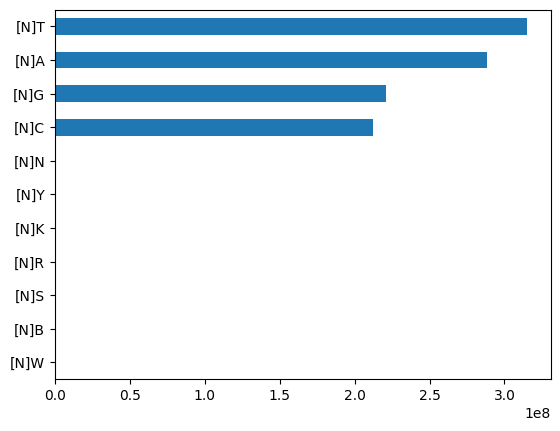

In [ ]:
#| hide
gene_token_counts_df.sum().sort_values().plot(kind='barh')

#### Protein token counts

In [ ]:
#| hide
protein_token_counts = {}

# take 10 samples
training_annotations.sample(sample_n).progress_apply(
    lambda row: record_token_count(
        row.label_id, 
        row.protein_annotation, 
        protein_token_counts
    ),
    axis=1
)

  0%|                                                 | 0/10684 [00:00<?, ?it/s]

27598     None
101411    None
48325     None
78774     None
97967     None
          ... 
1305      None
74618     None
65597     None
5982      None
80562     None
Length: 10684, dtype: object

In [ ]:
#| hide
protein_token_counts_df = pd.DataFrame.from_dict(protein_token_counts, orient='index').fillna(0)
protein_token_counts_df.head()

,[exon],[intron],[A]-E-1,[A]-Q-3,[A]-Q-2,[A]-Q-1,[A]-L-3,[A]-L-2,[A]-L-1,[A]-S-3,...,[A]-E-2,[N]A,[N]G,[N]T,[N]C,[A]-U-3,[A]-U-2,[A]-U-1,[N]W,[N]N
rna-NM_001388041.1,1358.0,2714.0,32.0,30.0,30.0,30.0,45.0,45.0,45.0,38.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rna-XM_047442443.1,6463.0,55855.0,65.0,30.0,30.0,30.0,42.0,42.0,42.0,63.0,...,65.0,419.0,859.0,462.0,681.0,0.0,0.0,0.0,0.0,0.0
rna-XM_017017167.2,1434.0,32862.0,33.0,27.0,27.0,27.0,77.0,77.0,77.0,49.0,...,33.0,2803.0,3379.0,2902.0,3442.0,0.0,0.0,0.0,0.0,0.0
rna-XM_047435234.1,4196.0,86306.0,88.0,75.0,75.0,75.0,105.0,105.0,105.0,173.0,...,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rna-NM_001329536.1,477.0,6674.0,19.0,17.0,17.0,17.0,78.0,78.0,78.0,32.0,...,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#| hide
protein_token_counts_df_sum = protein_token_counts_df.sum()
protein_token_counts_df_sum.name = "count"
protein_token_counts_df_sum = protein_token_counts_df_sum.to_frame().reset_index(drop=False).rename({"index": "token"}, axis=1)
protein_token_counts_df_sum.loc[:, 'token_norm'] = protein_token_counts_df_sum.token.apply(lambda token: token.rsplit("-", 1)[0])
protein_token_counts_df_sum = protein_token_counts_df_sum.drop_duplicates(subset=['token_norm'])
protein_token_counts_df_sum.set_index("token_norm", inplace=True)
protein_token_counts_df_sum.head()

,token,count
token_norm,,
[exon],[exon],24368885.0
[intron],[intron],967862789.0
[A]-E,[A]-E-1,546626.0
[A]-Q,[A]-Q-3,372778.0
[A]-L,[A]-L-3,722536.0


In [ ]:
#| hide
# Amino acid labels
protein_token_is_amino_acid_mask = protein_token_counts_df_sum.index.map(lambda idx: idx.startswith("[A]"))

<Axes: ylabel='token_norm'>

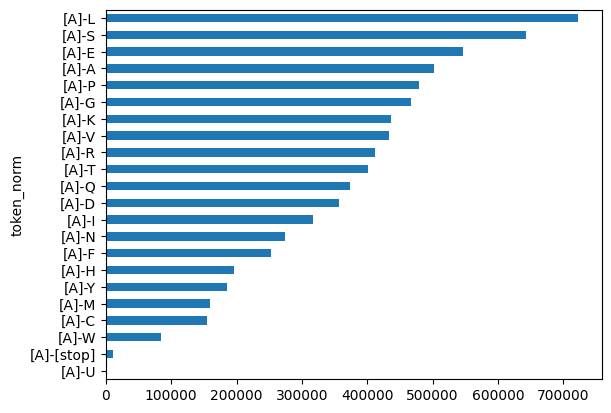

In [ ]:
#| hide
protein_token_counts_df_sum[protein_token_is_amino_acid_mask]['count'].sort_values().plot.barh()

<Axes: ylabel='token_norm'>

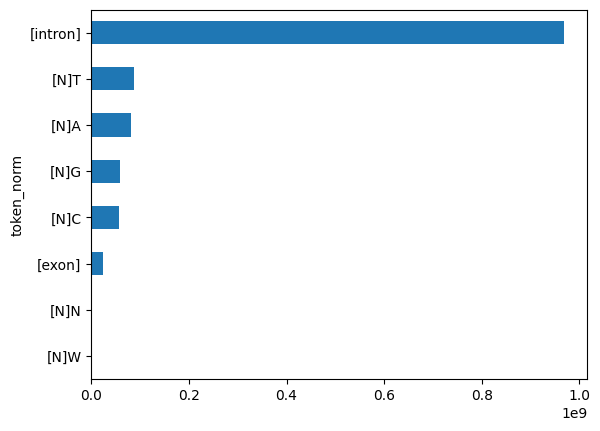

In [ ]:
#| hide
# Nucleotides in the label sequences
protein_token_counts_df_sum[~protein_token_is_amino_acid_mask]['count'].sort_values().plot.barh()

In [ ]:
#| hide
protein_token_counts_df_sum.loc["[intron]", "count"], protein_token_counts_df_sum.loc["[A]-L", "count"]

(967862789.0, 722536.0)

In [ ]:
#| hide
# Nucleotide + intron / exon vs amino acid tokens
protein_vs_gene_annotation_proportion = (
    protein_token_counts_df_sum[protein_token_is_amino_acid_mask]['count'].mul(3).div(sample_proportion).sum() / \
    protein_token_counts_df_sum[~protein_token_is_amino_acid_mask]['count'].sum()
) * 100

"Amino acids make up {:0.2f}% of all label tokens".format(protein_vs_gene_annotation_proportion)

'Amino acids make up 17.42% of all label tokens'

#### Takeaways

Genes (input)
- The input gene annotations have some "wildcard" nucleotide annotations. These nucleotide values reflect that in sequencing, the nucleotide read at that position could be one or more different nucleotides.
- The most prevalent nucleotide is Thymine, with 315,179,516 tokens

Proteins (labels)
- The labels are still largely genomic information, less than 18% of annotation tokens are amino acid related.
- The most prevalent mRNA annotation is [intron], with 967,862,789 tokens
- The most prevalent amino acid annotation is Leucine, with 722,536 tokens

Overall
- As it stands, we may want to consider weighting training instances so that the model can better learn what drives translation. As it is it may learn what creates an intron more than anything and miss the point of what we are trying to do.

### The effect of window size

> "How many training instances do we have if we institute a window size of size *n*?"

In [ ]:
#| hide
window_sizes = [
    512,
    1024,
    2048,
    4096,
    8192,
    16384,
    32768,
    65536
]

In [ ]:
#| export
def count_training_instances_with_window_size(annotation_size: int, window_sizes: list[int]) -> dict:
    instance_counts = {}
    for window in window_sizes:
        instance_counts[window] = math.floor(annotation_size / window)
    return instance_counts

In [ ]:
#| hide
gene_annotation_window_size_instances = gene_annotation_lengths_df.length.apply(
    lambda l: count_training_instances_with_window_size(l, window_sizes)
).apply(pd.Series)
gene_annotation_window_size_instances.head()

,512,1024,2048,4096,8192,16384,32768,65536
100129480,41,20,10,5,2,1,0,0
100131827,177,88,44,22,11,5,2,1
100132146,27,13,6,3,1,0,0,0
10015,138,69,34,17,8,4,2,1
100288801,5,2,1,0,0,0,0,0


In [ ]:
#| hide
gene_annotation_window_size_instances.sum()

512      2018346
1024     1005306
2048      498835
4096      245699
8192      119220
16384      56285
32768      25339
65536      10542
dtype: int64

In [ ]:
#| hide
protein_annotation_window_size_instances = protein_annotation_lengths_df.length.apply(
    lambda l: count_training_instances_with_window_size(l, window_sizes)
).apply(pd.Series)
protein_annotation_window_size_instances.head()

,512,1024,2048,4096,8192,16384,32768,65536
rna-NM_001142426.2,24,12,6,3,1,0,0,0
rna-NM_005834.5,9,4,2,1,0,0,0,0
rna-XM_011529575.4,1064,532,266,133,66,33,16,8
rna-NM_198382.3,130,65,32,16,8,4,2,1
rna-NM_001142502.2,52,26,13,6,3,1,0,0


In [ ]:
#| hide
# Account for sample size
protein_annotation_window_size_instances.sum().mul(10)

512      24933310
1024     12440540
2048      6193530
4096      3070390
8192      1508450
16384      728420
32768      339830
65536      149620
dtype: int64

#### Takeaways

- The "normal" window size of 512 gives us the most training instances of nearly 25 million.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()